In [1]:
# Imports
import csv
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.preprocessing import KBinsDiscretizer

# Intro
The relationship between the musical characteristics of each song and the popularity of each song is important for music production and song artists companies to create the next bit songs hits. This Spotify dataset contains songs that were on the Top 200 Weekly Global charts for Spotify in 2020 & 2021 along with each song’s genre, song artist ID, and various musical attributes. The highest charting position of each song is a number ranging from 1 to 100 that indicates the highest position the song ever ranked. In this project, we will attempt to predict song genre based on both song metadata as well as musical features generated by Spotify in-house algorithms. We will also try to predict the highest charting position of each song. Our classification algorithm can be used by musical production companies and song artists to gauge how certain metrics relate to genre, how genre can be predicted based on these features, and how these features relate to the ability of the song to make the top charts.

# Data Prep

This dataset contains songs that were on the Top 200 Weekly Global charts for Spotify in 2020 & 2021. For each song, we have the following features.

| Feature                   | Feature Type |
|---------------------------|--------------|
| Highest Charting Position | Numeric      |
| Number of Times Charted   | Numeric      |
| Song Name                 | Categorical  |
| Song ID                   | Categorical  |
| Artist                    | Categorical  |
| Streams                   | Numeric      |
| Artist Followers          | Numeric      |
| Genre                     | Categorical  |
| Release Date              | Numeric      |
| Weeks Charted             | Numeric      |
| Popularity                | Numeric      |
| Danceability              | Numeric      |
| Acousticness              | Numeric      |
| Energy                    | Numeric      |
| Instrumentalness          | Numeric      |
| Loudness                  | Numeric      |
| Speechiness               | Numeric      |
| Tempo                     | Numeric      |
| Valence                   | Numeric      |
| Chord                     | Numeric      |



In [2]:
# Entire Dataset
path = 'spotify_dataset.csv'
data = pd.DataFrame(pd.read_csv(path))
data.head()

,Index,Highest Charting Position,Number of Times Charted,Week of Highest Charting,Song Name,Streams,Artist,Artist Followers,Song ID,Genre,...,Danceability,Energy,Loudness,Speechiness,Acousticness,Liveness,Tempo,Duration (ms),Valence,Chord
0,1,1,8,2021-07-23--2021-07-30,Beggin',"48,633,449",Måneskin,3377762,3Wrjm47oTz2sjIgck11l5e,"['indie rock italiano', 'italian pop']",...,0.714,0.8,-4.808,0.0504,0.127,0.359,134.002,211560,0.589,B
1,2,2,3,2021-07-23--2021-07-30,STAY (with Justin Bieber),"47,248,719",The Kid LAROI,2230022,5HCyWlXZPP0y6Gqq8TgA20,['australian hip hop'],...,0.591,0.764,-5.484,0.0483,0.0383,0.103,169.928,141806,0.478,C#/Db
2,3,1,11,2021-06-25--2021-07-02,good 4 u,"40,162,559",Olivia Rodrigo,6266514,4ZtFanR9U6ndgddUvNcjcG,['pop'],...,0.563,0.664,-5.044,0.154,0.335,0.0849,166.928,178147,0.688,A
3,4,3,5,2021-07-02--2021-07-09,Bad Habits,"37,799,456",Ed Sheeran,83293380,6PQ88X9TkUIAUIZJHW2upE,"['pop', 'uk pop']",...,0.808,0.897,-3.712,0.0348,0.0469,0.364,126.026,231041,0.591,B
4,5,5,1,2021-07-23--2021-07-30,INDUSTRY BABY (feat. Jack Harlow),"33,948,454",Lil Nas X,5473565,27NovPIUIRrOZoCHxABJwK,"['lgbtq+ hip hop', 'pop rap']",...,0.736,0.704,-7.409,0.0615,0.0203,0.0501,149.995,212000,0.894,D#/Eb


## Cleaning the dataset

### Removing irrelevant columns and missing values
For our analysis, we will exclude song name and song ID from our feature set. These features do not give any information that would be pertinent to classifying the genre of each song. We will also drop any records that do not have any classified song genres, chords, or duration recorded as these are considered incomplete records. We chose to drop these records as opposed to replacing values with the mean for that feature because each song varies significatly in terms of its features and there is no "true average" for each feature.

In [3]:
# Drop columns corresponding to: index, song name, song id
columns_to_exclude = [0, 4, 8]
data.drop(columns=data.columns[columns_to_exclude], inplace=True)

# some songs have no defined Chord
print('Songs with no defined Chord', np.sum([data['Chord'] == ' ']))
# some song have not defined genre
print("Song with no defined genre", np.sum([data['Genre'] == '[]']))
# some songs have no defined duration
print('Songs with no defined Duration', np.sum([data["Duration (ms)"] == ' ']))

# Drop rows with missing values
data['Chord'].replace(' ', np.nan, inplace=True)
data['Genre'].replace('[]', np.nan, inplace=True)
data['Duration (ms)'].replace(' ', np.nan, inplace=True)
data.dropna(inplace=True)

Songs with no defined Chord 11
Song with no defined genre 75
Songs with no defined Duration 11


### Fixing Data Types

This was done to make the calculations and comparisons during exploration easier since each feature would have the same data type.


In [4]:
# fixing dtypes of values, so that they're floats
data['Streams'] = [int(stream.replace(',', '')) for stream in data['Streams'].tolist()]
types = {'Artist Followers':'int64', 'Duration (ms)':'int64', 'Popularity':'float','Danceability':'float', 'Acousticness':'float', 'Energy':'float', 'Liveness':'float','Loudness':'float', 'Speechiness':'float', 'Tempo':'float', 'Valence':'float'}
data = data.astype(types)

### Mapping Categorical Features to Classes

We mapped the artist feature to a new feature "Artist Class". This avoids dealing with string names in classification and instead, each artist corresponds to a unique identifier for that artist. The chord feature and genre feature were also engineered into new classes "Chord Class" and "Genre Class" for the same reason.

In [5]:
# Converting each artist to a class
artists = data['Artist'].tolist()
artists_set = set()
for artist in artists:
    multiple_artists = artist.split(", ")
    for each_artist in multiple_artists:
        artists_set.add(each_artist)

classes = range(len(artists_set))
artists_to_class = dict(zip(artists_set, classes))

# Adding classes as a column
artist_column = [[artists_to_class.get(each_artist) for each_artist in artist.split(", ")] for artist in artists]
data.insert(5, 'Artist_Class', artist_column)

In [6]:
# Converting each chord to a class
chords = set(data['Chord'].tolist())

classes = range(len(chords))
chords_to_class = dict(zip(chords, classes))

# Adding classes as a column
chord_column = [chords_to_class.get(chord_name) for chord_name in data['Chord'].tolist()]
data['Chord_Class'] = chord_column

In [7]:
popular = ["pop", "rock", "rap", "hiphop", "country", "latin", "other"]
latin = ["mexican", "sertanejo", "forro", "piseiro", "latin", "espanol"]
genres = []
# Checks if a genre is a latin genre
def is_latin(genre):
    for latin_genre in latin:
        if latin_genre in genre:
            return True
    return False

genre_feat = data["Genre"].tolist()
for feat_list in genre_feat:
    # Parse genres
    temp = feat_list.replace("'", "")
    temp = temp.replace("[", "")
    temp = temp.replace("]", "")
    temp = temp.replace(" ", "")
    feats  = temp.split(",")
    song_genre = set()
    # Replace all pop, rock, rap, and hiphop genres with general genres
    for feat in feats:
        if "pop" in feat:
            song_genre.add("pop")
        elif "rock" in feat:
            song_genre.add("rock")
        elif "rap" in feat or "brooklyndrill" in feat:
            song_genre.add("rap")
        elif "hiphop" in feat:
            song_genre.add("hiphop")
        elif "country" in feat:
            song_genre.add("country")
        elif is_latin(feat):
            song_genre.add("latin")
    if (len(song_genre) == 0):
        song_genre.add("other")
    genres.append(song_genre)
        
# Find genre frequencies
genre_freq = Counter([genre for song_genres in genres for genre in song_genres])
# Replace song genres with the most common genre
for i in range(len(genres)):
    song_genres = list(genres[i])
    max_freq_genre = None
    max_freq = -1
    for j in range(len(song_genres)):
        if song_genres[j] in genre_freq:
            cur_freq = genre_freq.get(song_genres[j])
            if max_freq < cur_freq:
                max_freq = cur_freq
                max_freq_genre = song_genres[j]
    genres[i] = max_freq_genre

# Converting each genre to a class
unique_genres = set(genres)

classes = range(len(unique_genres))
genres_to_class = dict(zip(unique_genres, classes))

# Adding classes as a column
genre_column = [genres_to_class.get(genre_name) for genre_name in genres]
data['Genre_Class'] = genre_column


In [8]:
data.head()

,Highest Charting Position,Number of Times Charted,Week of Highest Charting,Streams,Artist,Artist_Class,Artist Followers,Genre,Release Date,Weeks Charted,...,Loudness,Speechiness,Acousticness,Liveness,Tempo,Duration (ms),Valence,Chord,Chord_Class,Genre_Class
0,1,8,2021-07-23--2021-07-30,48633449,Måneskin,[617],3377762,"['indie rock italiano', 'italian pop']",2017-12-08,2021-07-23--2021-07-30\n2021-07-16--2021-07-23...,...,-4.808,0.0504,0.1270,0.3590,134.002,211560,0.589,B,0,3
1,2,3,2021-07-23--2021-07-30,47248719,The Kid LAROI,[381],2230022,['australian hip hop'],2021-07-09,2021-07-23--2021-07-30\n2021-07-16--2021-07-23...,...,-5.484,0.0483,0.0383,0.1030,169.928,141806,0.478,C#/Db,5,1
2,1,11,2021-06-25--2021-07-02,40162559,Olivia Rodrigo,[57],6266514,['pop'],2021-05-21,2021-07-23--2021-07-30\n2021-07-16--2021-07-23...,...,-5.044,0.1540,0.3350,0.0849,166.928,178147,0.688,A,8,3
3,3,5,2021-07-02--2021-07-09,37799456,Ed Sheeran,[184],83293380,"['pop', 'uk pop']",2021-06-25,2021-07-23--2021-07-30\n2021-07-16--2021-07-23...,...,-3.712,0.0348,0.0469,0.3640,126.026,231041,0.591,B,0,3
4,5,1,2021-07-23--2021-07-30,33948454,Lil Nas X,[585],5473565,"['lgbtq+ hip hop', 'pop rap']",2021-07-23,2021-07-23--2021-07-30,...,-7.409,0.0615,0.0203,0.0501,149.995,212000,0.894,D#/Eb,4,3


# Data Exploration

After some data preparation, we explored the features and plotted their ranges to visualize any outliers in the dataset.

<ipython-input-9-057de388bfdf>:11: MatplotlibDeprecationWarning: normalize=None does not normalize if the sum is less than 1 but this behavior is deprecated since 3.3 until two minor releases later. After the deprecation period the default value will be normalize=True. To prevent normalization pass normalize=False 
  ax.pie(percentages, labels=labels)


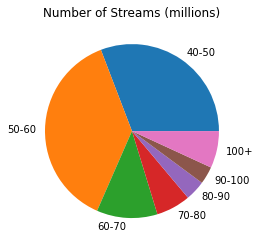

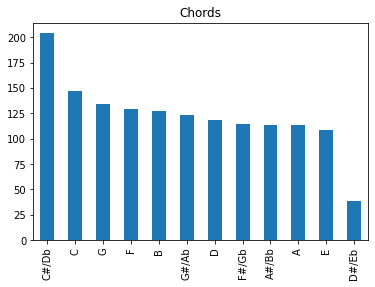

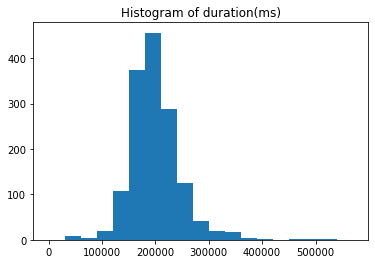

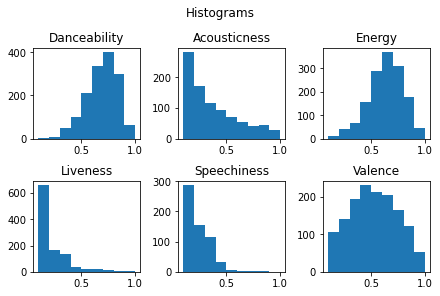

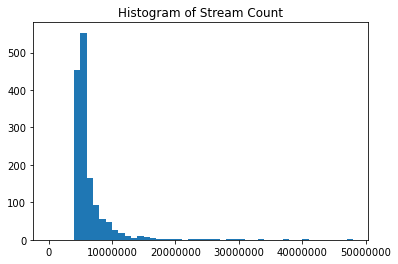

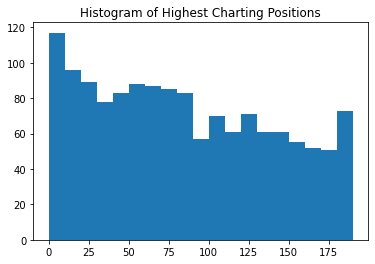

In [9]:
# Exploring and Checking for Noise and Outliers

stream_bins = list(range(0, 10000001, 1000000)) + [99999999]
# streams = [int(stream.replace(',', '')) for stream in data['Streams'].tolist()]
hist, bin_edges = np.histogram(data['Streams'], bins=stream_bins)
percentages = hist/np.sum(hist)
labels = np.array(['0-10', '10-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80-90', '90-100', '100+'])
labels = labels[percentages != 0]
percentages = percentages[percentages != 0]
fig, ax = plt.subplots(1, 1)
ax.pie(percentages, labels=labels)
ax.set_title('Number of Streams (millions)')
plt.show()

# should sort chords from low to high?
ax = data['Chord'].value_counts().plot.bar()
ax.set_title('Chords')
plt.show()

duration_bins = list(range(0, 30000*2*10, 30000))
fig, ax = plt.subplots(1, 1)
ax.hist(pd.to_numeric(data["Duration (ms)"]), bins=duration_bins)
ax.ticklabel_format(style='plain')
ax.set_title('Histogram of duration(ms)')
plt.show()

zero_to_one_bins = np.linspace(0.1, 1.0, 10)
fig, ax = plt.subplots(2, 3, constrained_layout=True)
zero_to_one_columns = ['Danceability', 'Acousticness', 'Energy', 'Liveness', 'Speechiness', 'Valence']
for i in range(len(zero_to_one_columns)):
    idx = np.unravel_index(i, (2, 3))
    ax[idx].hist(pd.to_numeric(data[zero_to_one_columns[i]]), bins=zero_to_one_bins)
    ax[idx].set_title(zero_to_one_columns[i])
fig.suptitle('Histograms')
plt.show()

duration_bins = list(range(0, max(data['Streams']), 1000000))
fig, ax = plt.subplots(1, 1)
ax.hist(pd.to_numeric(data["Streams"]), bins=duration_bins)
ax.ticklabel_format(style='plain')
ax.set_title('Histogram of Stream Count')
plt.show()

duration_bins = list(range(0, max(data['Highest Charting Position']), 10))
fig, ax = plt.subplots(1, 1)
ax.hist(pd.to_numeric(data['Highest Charting Position']), bins=duration_bins)
ax.ticklabel_format(style='plain')
ax.set_title('Histogram of Highest Charting Positions')
plt.show()

In [10]:
# Exploring 

data.groupby('Number of Times Charted').describe()['Highest Charting Position']

,count,mean,std,min,25%,50%,75%,max
Number of Times Charted,,,,,,,,
1,491.0,128.949084,47.672859,5.0,87.00,134.0,171.0,200.0
2,146.0,81.767123,50.590178,10.0,43.00,66.5,111.5,194.0
3,106.0,82.754717,55.189166,2.0,34.00,71.0,128.0,193.0
4,67.0,86.119403,53.110098,10.0,49.00,71.0,132.0,194.0
5,66.0,79.333333,51.563354,3.0,38.25,69.5,120.0,189.0
...,...,...,...,...,...,...,...,...
81,2.0,61.000000,28.284271,41.0,51.00,61.0,71.0,81.0
82,2.0,57.000000,52.325902,20.0,38.50,57.0,75.5,94.0
83,15.0,27.133333,31.854281,1.0,4.00,13.0,38.5,99.0


In [11]:
# Exploring

data.corr(method='pearson')

,Highest Charting Position,Number of Times Charted,Streams,Artist Followers,Popularity,Danceability,Energy,Loudness,Speechiness,Acousticness,Liveness,Tempo,Duration (ms),Valence,Chord_Class,Genre_Class
Highest Charting Position,1.000000,-0.410595,-0.298790,-0.247796,-0.320234,0.021647,0.061294,0.033320,0.045668,-0.021258,0.005447,0.026284,-0.037091,0.051415,0.006767,-0.025047
Number of Times Charted,-0.410595,1.000000,-0.061799,0.035791,0.455422,0.024082,-0.046415,0.047012,-0.068676,0.041189,-0.050636,-0.049898,0.035513,0.024569,-0.021123,0.077230
Streams,-0.298790,-0.061799,1.000000,0.100240,0.142846,-0.086556,0.004738,-0.030966,-0.061597,0.037113,0.043044,0.057788,0.017649,0.033661,-0.000698,0.000869
Artist Followers,-0.247796,0.035791,0.100240,1.000000,0.003354,-0.107970,-0.072213,-0.036164,-0.087508,0.041055,-0.020931,-0.016717,0.133528,-0.102008,0.035807,0.178516
Popularity,-0.320234,0.455422,0.142846,0.003354,1.000000,0.039565,0.111469,0.200443,-0.098915,-0.095474,-0.087994,-0.042767,0.078418,0.017242,-0.026172,0.145511
Danceability,0.021647,0.024082,-0.086556,-0.107970,0.039565,1.000000,0.139572,0.234814,0.238119,-0.317818,-0.117369,-0.030442,-0.106726,0.357089,-0.084303,-0.115465
Energy,0.061294,-0.046415,0.004738,-0.072213,0.111469,0.139572,1.000000,0.729818,0.026659,-0.539711,0.124064,0.110788,0.064591,0.346834,0.002234,0.080119
Loudness,0.033320,0.047012,-0.030966,-0.036164,0.200443,0.234814,0.729818,1.000000,-0.013791,-0.473206,0.040444,0.104720,0.086502,0.287641,0.009745,0.118508
Speechiness,0.045668,-0.068676,-0.061597,-0.087508,-0.098915,0.238119,0.026659,-0.013791,1.000000,-0.135121,0.077980,0.116961,-0.094616,0.046691,-0.028891,-0.208232
Acousticness,-0.021258,0.041189,0.037113,0.041055,-0.095474,-0.317818,-0.539711,-0.473206,-0.135121,1.000000,-0.000010,-0.069064,-0.045929,-0.094596,0.029274,0.006693


# Feature Engineering

In [12]:
# Clean data a bit more
# drop non-number data (including data we've converted to numbers)
cols_to_drop = ['Week of Highest Charting', 'Artist', 'Genre', 'Release Date', 'Weeks Charted', 'Chord']
data_only_nums = data.drop(cols_to_drop, axis=1)

# only consider first artist for ease, round streams
data_only_nums['Artist_Class'] = data_only_nums.apply(lambda x: x[0], axis=1)

# round streams so we have a chance at predicting it well
data_only_nums['Streams'] = (data_only_nums['Streams'] / 10000000).astype(int) * 10000000
data_only_nums['Artist Followers'] = (data_only_nums['Artist Followers'] / 100000).astype(int) * 100000
print(data_only_nums.head())

   Highest Charting Position  Number of Times Charted   Streams  Artist_Class  \
0                          1                        8  40000000             1   
1                          2                        3  40000000             2   
2                          1                       11  40000000             1   
3                          3                        5  30000000             3   
4                          5                        1  30000000             5   

   Artist Followers  Popularity  Danceability  Energy  Loudness  Speechiness  \
0           3300000       100.0         0.714   0.800    -4.808       0.0504   
1           2200000        99.0         0.591   0.764    -5.484       0.0483   
2           6200000        99.0         0.563   0.664    -5.044       0.1540   
3          83200000        98.0         0.808   0.897    -3.712       0.0348   
4           5400000        96.0         0.736   0.704    -7.409       0.0615   

   Acousticness  Liveness    Tem

In [13]:
# Create data/labels frames
genre_labels = data_only_nums['Genre_Class'].values.ravel()
genre_data = data_only_nums.drop(['Genre_Class'], axis=1)

charting_labels = data_only_nums['Highest Charting Position']
charting_data = data_only_nums.drop(['Highest Charting Position'], axis=1)

# Bin the highest charting positions
discretize = KBinsDiscretizer(n_bins=20, encode='ordinal', strategy='uniform')
charting_labels = np.array(charting_labels).reshape(-1, 1)
discretize.fit(charting_labels)
charting_labels = pd.Series(discretize.transform(charting_labels).flatten())


print('Genre Data Shape:', genre_data.shape, '\nGenre Labels Shape:', len(genre_labels))
print('Charting Data Shape:', charting_data.shape, '\nCharting Labels Shape:', len(charting_labels))

Genre Data Shape: (1470, 16) 
Genre Labels Shape: 1470
Charting Data Shape: (1470, 16) 
Charting Labels Shape: 1470


## Addressing Class Imbalances
From our visualization of the song genres and top charting positions, we can see that there are class imbalances in our dataset

# Data Analysis

## Decision Tree

In [14]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from imblearn.pipeline import make_pipeline as make_pipeline_with_sampler
from imblearn.under_sampling import TomekLinks

def do_decision_tree(data, labels, label_name):
    # fit a decision tree classifier across 5 cross folds
    clf = DecisionTreeClassifier(criterion='entropy')
    
    pipe = make_pipeline_with_sampler(        
                                    TomekLinks(),
                                    clf
            )
    
    accuracies = cross_val_score(clf, data, labels, cv=5)
    print('Average Accuracy of a Decision Tree on Predicting', label_name, '%.4f%%' % (np.mean(accuracies) * 100))

do_decision_tree(genre_data, genre_labels, 'Genre')
do_decision_tree(charting_data, charting_labels, 'Highest Charting Position')

Average Accuracy of a Decision Tree on Predicting Genre 64.2177%
Average Accuracy of a Decision Tree on Predicting Highest Charting Position 100.0000%


### Results
A decision tree working this well with our data is surprising, especially with how well it can predict charting position! This is likely due to the fact that there are a lot of numerical features such as danceability and energy. This allows the tree to split on these features and make more accurate predictions.

## KNN

In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

def do_knn(data, labels, label_name):
    # Standardize features
    scalar = StandardScaler()

    # PCA
    pca = PCA()

    # KNN 
    knn = KNeighborsClassifier(n_neighbors=7)

    # Pipeline 
    steps = [('scaler', scalar), ('pca', pca), ('knn', knn)]
    pipe = make_pipeline_with_sampler(        
                                    scalar,
                                    pca,
                                    TomekLinks(),
                                    knn
            )
    # pipe = Pipeline(steps)

    # 5-fold cv
    accuracies = cross_val_score(pipe, data, labels, cv=5)
    print('Average Accuracy of KNN on', label_name, ': %.4f%%' % (accuracies.mean() * 100))

do_knn(genre_data, genre_labels, "Genre")
do_knn(charting_data, charting_labels, "Highest Charting Position")

Average Accuracy of KNN on Genre : 57.6190%
Average Accuracy of KNN on Highest Charting Position : 15.8503%


### Results
While KNN performed similarly to the decision tree for predicting genre, KNN did much worse with predicting highest charting position. In order to try and improve this classification, we will reduce the dimensionality of our data by pruning extraneous features and only including columns like "danceability", "tempo", etc which are directly related to the song.

In [16]:
genre_drop_cols = ['Highest Charting Position', 'Number of Times Charted', 'Streams', 'Artist_Class', 'Artist Followers', 'Popularity']
charting_drop_cols = ['Genre_Class', 'Number of Times Charted', 'Streams', 'Artist_Class', 'Artist Followers', 'Popularity']
new_genre_data = genre_data.drop(genre_drop_cols, axis=1)
new_charting_data = charting_data.drop(charting_drop_cols, axis=1)

do_knn(new_genre_data, genre_labels, 'New Genre')
do_knn(new_charting_data, charting_labels, 'New Highest Charting Position')

Average Accuracy of KNN on New Genre : 59.4558%
Average Accuracy of KNN on New Highest Charting Position : 6.4626%


This general dimensionality reduction actually reduced the accuracy of KNN in predicting highest charting position. This may be reconciled based on the information we lost during reduction. It is possible that artists with more followers will probably tend to have higher charting positions with their song than someone else who may happen to have a similar "danceability" rating. Because of this, features like artist followers that are not directly related to the song may allow for better prediction of charting position than features more correlated with the song like dancability and tempo since these are more generalized across the music industry.

## Ensemble (Adaboost)

In [17]:
from sklearn.ensemble import AdaBoostClassifier

def do_adaboost(data, labels, label_name):
    tree = DecisionTreeClassifier(criterion='entropy')
    clf = AdaBoostClassifier(base_estimator=tree, n_estimators=25)

    pipe = make_pipeline_with_sampler(
        TomekLinks(),
        clf
    )

    accuracies = cross_val_score(pipe, data, labels, cv=2)
    print('Average Accuracy of Adaboost on', label_name, ': %.4f%%' % (accuracies.mean() * 100))

do_adaboost(genre_data, genre_labels, 'Genre')
do_adaboost(charting_data, charting_labels, 'Highest Charting Position')

Average Accuracy of Adaboost on Genre : 57.2789%
Average Accuracy of Adaboost on Highest Charting Position : 99.1837%


### Results
The ensemble method of classification does a similar job at classifying genre as decision trees and KNN. However, it is very accurate in terms of prediction highest charting position. This is likely because AdaBoost is boosting the more difficult to classify records and giving them a higher weight in the next model instance. 

## Overall Conclusions
In order to predict genre and highest charting position, we used three classifiers: decision tree, KNN, and ensemble method with boosting. Prior to classification, in data preparation, we removed extraneous features such as song ID and mapped categorical features to numeric. Then, in data exploration, we visualized the range of each feature to easily remove any noise in the data or outliers for a particular feature. For feature engineering, we modulated some features for easier classification such as only considering the first artist on the song and rounding streams for better predictions. Then, the data was ready for classiication. For genre, the accuracy of predictions were 63.06% (decision tree), 58.91% (KNN), and 56.73% (ensemble boosting). These accuracies are all pretty similar with decision tree doing the best. For highest charting position, the prediction accuracies were 100% (decision tree), 14.9% (KNN), and 99.18% (ensemble boosting). We attempted to improve the accuracy of the KNN classifier through dimensionality reduction, but this actually diminished the accuracy. This is likely due to the fact that when dimensionality is reduced, information is lost from the dataset that may be useful to the classfier. Overall, the decision tree classifier performed the best at predicting the genre and highest charting position of the songs in this Spotify dataset.